# &#x1F4DD; REPORT

## &#x0031;&#xFE0F;&#x20E3; Receiver for NR Secondary Synchronization Signals (SSS)

### &#x0031;&#xFE0F;&#x20E3;.&#x0031;&#xFE0F;&#x20E3; SSS signals

The SSS is an BPSK-modulated OFDM signal comprising 127 subcarriers in subcarriers 56-182 of symbol 2 in the so-called SSB block(see slides). The position of the SSB block is determined from the position of the PSS that was detected.

We are concerned with complex baseband equivalent transmit signals as in lab session 1. For all signals in this lab session, as in the first lab, the sampling rate is assumed to be 61.44 Msamples/s.

#### &#x0031;&#xFE0F;&#x20E3;.&#x0031;&#xFE0F;&#x20E3;.&#x0031;&#xFE0F;&#x20E3; Questions

##### &#x0031;&#xFE0F;&#x20E3; you will need the results of the first lab session, specifically the time-synchronization implementation and the signal files that you used before. If needed, we will acquire more signal files.

In [1]:
using Plots
using FFTW
using LinearAlgebra

&#x1F4D1; Note: the `operations.jl` source code helps writting mathematical symbols:
For example:
- `Fᴵ` replaces the `ifft` function (inverse Fourier Transform)
- the convolution sign `⊗` is used rather than the `conv` function
- the reverse sign `⦰` is also used to replace the `reverse` function
- the concatenation sign `⧺` is used to make a vertical concatenation operation
- the transpose function `(.)ᵀ` is use to transpose a vector or a matrix 

In [2]:
include("../modules/operations.jl");

&#x1F4D1; Note: Greek letters are also used wherever it makes sense

- along with the greek laters LaTeX notations are extensively incorporated
- this with the hope to better correlate the Mathematical symbols and notations used in different documents

In [3]:
using LaTeXStrings

In [4]:
using DSP

##### &#x0030;&#xFE0F;&#x20E3;  Implementing the Receiver from Lab1

The primary objective is to determine the most likely $i$, or index of the transmitted PSS. In addition we would like to have the best estimate of $N\mathcal{f}$ and $\Delta \mathcal{f}$ since these are required to detect the other signal components after the PSS (Lab session 2). This will be investigated in other lab sessions. There are different approaches to doing this, but here we will take the approach where Nf and ∆f are discretized and are detected in a similar fashion to $i$. Let us assume that $N\mathcal{f}$ is discretized to the resolution of one sample. Since the periodicity of the PSS is $N$ samples, $N\mathcal{f}$ can assume the values ${0, 1, · · · , N − 1}$. Although a purely continuous random variable, we will also discretize $\Delta \mathcal{f}$ as 

$$\Delta \mathcal{f} = m \Delta \mathcal{f}_{min}, m = − \Delta \mathcal{f}_{max}/\Delta \mathcal{f}_{min}, · · · , \Delta \mathcal{f}_{max}/\Delta \mathcal{f}_{min}$$

, where $\Delta \mathcal{f}_{max}$ is the largest frequency-offset we are likely to encounter. Under these assumptions we will consider the following detection rule for the triple $(i, N\mathcal{f} , m)$

$$(\hat{i},\hat{N}\mathcal{f},\hat{m}) = argmax \; Y(i, N\mathcal{f} , m)$$

where $Y (i, N\mathcal{f} , m)$ will be chosent as the following statistic:

$$Y (i, N\mathcal{f} , m) = \left| \sum_{n=0}^{N_{PSS - 1}}e^{- 2 \pi j n m \Delta \mathcal{f}_{min} / \mathcal{f}_s}x_i^* (n)y(n + Nf ) \right|^2 $$


In [5]:
𝑓ₛ = 61.44 * 1e6; @show 𝑓ₛ # samples/s
Nᵨ = 1e-2; @show Nᵨ # typed \N\_rho for ratio to the sampling frequency in samples/s
𝑁τ = Nᵨ * 𝑓ₛ ; @show 𝑁τ; # Periodicity 
𝐶ₚ = 144; # Cyclic Prefix

𝑓ₛ = 6.144e7
Nᵨ = 0.01
𝑁τ = 614400.0


In [6]:
Nₒₛ = 2048; @show Nₒₛ;  # OFDM Symbol Size
𝑁ₚₛₛ = Nₒₛ + 𝐶ₚ; @show 𝑁ₚₛₛ; # Duration = PSS Signal + Cyclic Prefix samples

Nₒₛ = 2048
𝑁ₚₛₛ = 2192


In [7]:
## Receive the signal
include("../data/julia/rxsignal_withchannelandfreqoff.jl");

&#x1F4D1; Note: the `Julia` files translating the `MATLAB` files are located under the `../data/julia` directory. The `Julia` files are just reading the `MATLAB`'s files by using the `MAT` Julia Library. 

Below a Julia source code example opening the `.mat` MATLAB original file and reading the `rxs3` signal.

```julia
using MAT

ff = matopen("../data/matlab/rxsignal_withchannelandfreqoff.mat");

@read ff rxs3;
```

The original `MATLAB` data files are located under the `../data/matlab` folder and have `NOT` been modified nor altered. 

In [8]:
using FFTW
using DSP

In [9]:
## Assign the received signal a variable sᵣₓ³
sᵣₓ³ = rxs3; # RX Received Signal 3 File Handle
@show size(sᵣₓ³), typeof(sᵣₓ³);

(size(sᵣₓ³), typeof(sᵣₓ³)) = ((616447, 1), Matrix{ComplexF64})


In [10]:
using LinearAlgebra

In [11]:
## Load the template signal
include("../data/julia/pss2.jl");

In [12]:
## Assign the reference signal to a variable s̃ₚₛₛ²
## convert the signal in time domain
s̃ₚₛₛ² = pss_2;      # file handle #typed H\overbar 
s̃ₚₛₛ² = 𝓕⁻¹(s̃ₚₛₛ²);   # (inverse fourier transform) in time domain typed s\tilde
s̃ₚₛₛ² ./= norm(s̃ₚₛₛ²);  @show size(s̃ₚₛₛ²), 𝐶ₚ-1    # Normalize
s̃ₚₛₛ² = s̃ₚₛₛ²[(end-(𝐶ₚ-1)):end] ⧺ s̃ₚₛₛ² # align verticaly end is 2048 FFT size
@show size(s̃ₚₛₛ²), typeof(s̃ₚₛₛ²); 

(size(s̃ₚₛₛ²), 𝐶ₚ - 1) = ((2048,), 143)
(size(s̃ₚₛₛ²), typeof(s̃ₚₛₛ²)) = ((2192,), Vector{ComplexF64})


In [13]:
## Prepare the reference signal for convolution
s̃ₚₛₛ²ˣ = (⦰(s̃ₚₛₛ²))ˣ; # reverse conjugate in one operation otherwise can lose peak
@show length(s̃ₚₛₛ²ˣ), typeof(s̃ₚₛₛ²ˣ);

(length(s̃ₚₛₛ²ˣ), typeof(s̃ₚₛₛ²ˣ)) = (2192, Vector{ComplexF64})


In [14]:
## Perform the convolution between the 2 signals
rᵣₓ³ = 10 * log10.(abs.( sᵣₓ³ ⊗ s̃ₚₛₛ²ˣ ))
@show size( rᵣₓ³ ), typeof(rᵣₓ³); 

(size(rᵣₓ³), typeof(rᵣₓ³)) = ((618638, 1), Matrix{Float64})


In [15]:
# Find maximum value and its index
# This part is blurry and needs to be correlated to the TP1 Handout explanation
# to determine the right variable naming
Ĉᵩ², 𝑁̂𝑓² = argmax(rᵣₓ³); @show Ĉᵩ², 𝑁̂𝑓²;
N𝑓 = getindex(𝑁̂𝑓², 1) - length(s̃ₚₛₛ²) + 1; @show N𝑓, getindex(𝑁̂𝑓², 1);

(Ĉᵩ², 𝑁̂𝑓²) = (50.649042476081405, CartesianIndex(6628, 1))
(N𝑓, getindex(𝑁̂𝑓², 1)) = (4437, 6628)


In [16]:
# Plot the result and notice the peak at 50
m3_chan_plot = 
plot(rᵣₓ³, xlabel="Sample", ylabel="Power (dB)", title="Convolution Result"
    , label = "rᵣₓ³"
    , ylim=(-20, 60), size = (800,600))
savefig(m3_chan_plot,"images/m3_chan_plot.png");

![title](images/m3_chan_plot.png)

### Set the variables from the TP1 Handout

In [17]:
Δ𝑓ₘᵢₙ =    10.0 
𝑓₋    = -7500.     # f_min
𝑓₊    =  7500.     # f_max
m     = 𝑓₋:Δ𝑓ₘᵢₙ:𝑓₊

Nₒₛ = 2048; @show Nₒₛ;  # OFDM Symbol Size
𝑓ₛ / Nₒₛ # Frequency Resolution

Nₒₛ = 2048


30000.0

In [18]:
########################################################
# Frequency Offset Estimator Function
########################################################
function freq_offset_est(sₚₛₛ, hₚₛₛ, Nf, m, 𝑓ₛ)

    # Frequency offset estimator
    Y = zeros(Float64, length(m));
    L = length(hₚₛₛ)
    t = 0:(1/𝑓ₛ):((L-1)/𝑓ₛ)

    for i = 1:length(m)
        # vec() denote the operation of reshaping sequence into a one-dimensional vector
        # in Matlab it is the .' (per element transpose)
        # (.)ˣ is the conjugate operation
        Y[i] += abs2.( ∑( exp.(-2π * j * m[i] .*t ) .* (hₚₛₛ)ˣ .* vec(sₚₛₛ[Nf:(Nf + L -1)])));
    end

    A𝑓ₒ, 𝑓ₒ = argmax(Y) # Frequency Offset Ampitude, Index and adjusted signal

    return m[𝑓ₒ], A𝑓ₒ, 𝑓ₒ, Y # m[𝑓ₒ] Index of the transmitted PSS in Hz
end

freq_offset_est (generic function with 1 method)

In [19]:
# Grab the Prof's Frequency Offset function with his values
i, A𝑓ₒ, 𝑓ₒ, Y = freq_offset_est(sᵣₓ³, s̃ₚₛₛ², N𝑓, m, 𝑓ₛ); @show i, 10 * log10(A𝑓ₒ), 𝑓ₒ;

(i, 10 * log10(A𝑓ₒ), 𝑓ₒ) = (340.0, 101.30016881425944, 785)


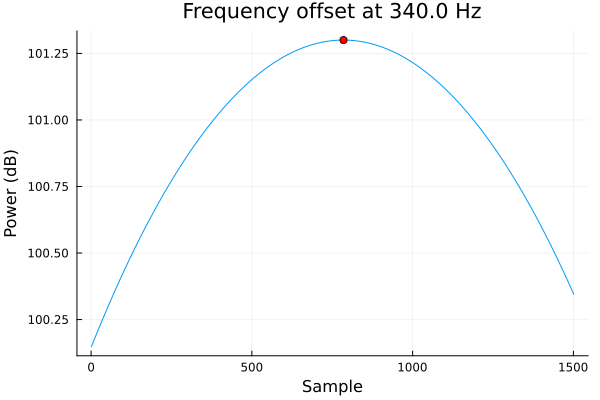

In [20]:
cfo_estim_plot = 
plot(10 * log10.(abs.(Y))
    , xlabel="Sample"
    , ylabel="Power (dB)"
    , title="Frequency offset at $i Hz"
)
scatter!((𝑓ₒ, (10 * log10(A𝑓ₒ))), color="red", label=:none, legend=:none)

In [21]:
# Compensate CFO by multiplying the received signal with a complex exponential
function compensate_cfo(rₚₛₛ, N̂𝑓, 𝑓ₛ, Npss)
    # Generate a complex exponential with the specified frequency offset
    # rₚₛₛ = rₚₛₛ .* exp.(-2π * j * collect(1:4*Npss) * (N̂𝑓/𝑓ₛ))

    t = 0:(1/𝑓ₛ):((Npss-1)/𝑓ₛ)
    rₚₛₛ = rₚₛₛ .* exp.(-2π * j .* N̂𝑓 .* t)

    return rₚₛₛ
end

compensate_cfo (generic function with 1 method)

In [22]:
s̃ᵣₓ³ = compensate_cfo(sᵣₓ³, i, 𝑓ₛ, length(sᵣₓ³));

In [23]:
# Plotting the real part of the original and corrected signals
pl1 = plot(abs.(sᵣₓ³), label="Original Signal", lw = 2)
pl1 = plot!(abs.(s̃ᵣₓ³), label="CFO Compensated Signal", title="CFO Compensation", xlabel="Time (s)", ylabel="Amplitude")
savefig(pl1, "images/cfo_comp.png");

![title](images/cfo_comp.png)

In [24]:
using DSP

In [25]:
Cᵣₓ³ = DSP.xcorr(vec(sᵣₓ³),vec(s̃ᵣₓ³)); 
plot00 = plot(10 * log10.(abs.(Cᵣₓ³)), label="Cᵣₓ³", title = "Correlate sᵣₓ³ and s̃ᵣₓ³ signals");
savefig(plot00,"images/xcorr_clo_comp.png");

![title](images/xcorr_clo_comp.png)

In [26]:
L = length(sᵣₓ³)
t = 0:(1/𝑓ₛ):((L-1)/𝑓ₛ) # Time vector

0.0:1.6276041666666667e-8:0.01003330078125

In [27]:
# Plotting the real part of the original and corrected signals
plt = plot(t, real(sᵣₓ³), label="Original Signal")
plt = plot!(t, real(s̃ᵣₓ³), label="CFO Compensated Signal", title="CFO Compensation", xlabel="Time (s)", ylabel="Amplitude")
savefig(plt,"images/cfo_com.png");

![title](images/cfo_com.png)

&#x1F4DD; SSS Constellation

I tried implementing the SSS constellation extracted from the PSS but I was not able to so I didn't put the code here

# &#x1F4DA; References

- [ ] [How can I define the frequency resolution in FFT? And what is the difference on interpreting the results between high and low frequency resolution?](https://www.researchgate.net/post/How-can-I-define-the-frequency-resolution-in-FFT-And-what-is-the-difference-on-interpreting-the-results-between-high-and-low-frequency-resolution)